In [42]:
import gdown
import geopandas as gpd
import matplotlib.pyplot as plt

from MLtools import inference, plotting
from pathlib import Path

### There are two ways to make predictions:
A. You can use the `predictions_stitching_filtering` function in the MLtools python package. <br>
B. or you can use directly the few functions provided on the Detectron2 platform (note that this step does not include any post-processing steps, and will give you only raw predictions). 

In both cases, the input image(s) need(s) to be selected and the paths to the model setup and weigths need to be specified. 

## A. Using the function *predictions_stichting_filtering*
### 1. Selection of a specific image (or multiple images)

#### Single image selection

In [3]:
#tif = Path("/home/nilscp/tmp/prediction_test/M1180981884LE_clipped.tif") 

#### Multiple images selection

In [ ]:
#input_folder = Path("/home/nilscp/tmp/tmp_pred")
#tifs = list(input_folder.rglob("*.tif"))

### 2. Setup of the model (load model setup and model weights)
Be sure that you have all of the inputs needed: 
1. Model setup file
2. Model weights
Both of those files can be downloaded from the project's GoogleDrive (please follow the instructions at: [DOWNLOAD_DATA_BOULDERING.ipynb](./DOWNLOAD_DATA_BOULDERING.ipynb))

In [4]:
home_p = Path.home()
work_dir = home_p / "tmp" / "BOULDERING"
model_dir = work_dir / "best_model"

BE CAREFUL, you have to modify the first line in the `model_setup.yaml` so that the path stored in the variable `_BASE_` corresponds to the actual path on your own computer.
```bash
_BASE_: <$HOME_DIRECTORY>/tmp/BOULDERING/best_model/base_setup.yaml
```
or
```bash
_BASE_: ./base_setup.yaml
```

In [6]:
config_file = model_dir / "model_setup-v050.yaml"
model_weights = model_dir / "model_weights.pth" # correspond to iteration 54,000
device = "cuda" # "cpu" or "cuda", see comment below, please run the predictions for large images on a computer with a graphical card. 

I would suggest you to run this function on a computer with a graphical card (e.g., "cuda"), as the function is not yet optimized, and takes a rather long amount of time to run. I will improve this function over time, but it may take a little bit of time...

### 3. predictions_stitching_filtering

There are many steps in this function. Here is a small summary of what happens.

#### A. Predictions for image patches having slightly different strides/shifts

In order to remove predictions which are cutted at the edge of image patches (see Fig 1.), we increase the amount of overlap between image patches. There are probably different ways of doing it (which are more effective), but we are here using 6 different strides/shifts setups to cover the whole image: 
1. Stride (0, 0)  
2. Stride (block_width/2, block_height/2)
3. Stride (block_width/2, block_height)
4. Stride (block_width, block_height/2)
5. Stride (0, block_height/2)
6. Stride (block_width/2, 0)

So, if you start with an original raster/image with 200 image patches along the x-axis, and 1000 along the y-axis. There will not be only 200x1000 image patches processed but, 4x200x1000 (for the four first stride setups), and 2x(1000 + 200) for the two last setups (as the two last setups were only needed for the image patches at the edge of the original raster/image). So from a starting number of 200,000 image patches, you end up having to process 802,400 image tiles! This increase slows significantly the time it takes to process a complete single Narrow Angle Camera (NAC) or (HiRISE). We will try to improve this step in the future. <br>

Note that this steps also include the tiling of the original raster/image into smaller image patches.

<center><img src="../images/image-20230807113604998.png"/></center>

*Figure 1. Example of edge artifacts.*

#### B. Select predictions only at centres of image patches (to avoid edge predictions)

Now that we have predicted boulders for a large number of image patches, we need to only select the predictions we are interested in. The way we have done it is to select only boulders within X% from the center of patches. We used a value X = distance_p = 62.5%, allowing for a little bit of overlapping. 

**Setup 1-4** Selecting (distance_p * 100) % from centre <br>
**Setup 5-6** Selecting all of the boulders at the top and bottommost tiles which are not covered by setup 1 to 4. <br>

#### C. Remove duplicate boulders with Non-Maximum Suppresion

The last step involves removing duplicate boulders with the help of non-maximum suppression (there are lot of resource on the internet about what non-maximum suppression is, e.g., [here](https://medium.com/mlearning-ai/a-deep-dive-into-non-maximum-suppression-nms-understanding-the-math-behind-object-detection-765ff48392e5)). Long story short, it is a good way to remove duplicate/overlapping predictions. 
   
#### D. Including Test Time Augmentation (TTA) or not? 
if the flag `is_tta` is set to *True*, every image patches will be rotated in 8 potential configurations (see Fig. 2), and predictions will be made for each of the rotation. Including TTA allows for the detection of additional boulders in image patches, however, it further increases the number of processed image patches by 8 (8 x 802,400 = 6,419,200). From the test we have run, TTA is increasing the detection rate by a few %. More test need to be conducted to contrain a bit more this value. Note that Non-Maximum Suppresion is again used to remove duplicated, and keep only the predictions with the highest score/confidence. <br>

After running the function, you end up with a shapfile with no edge artificats (Fig. 3). 

<center><img src="../images/image-20230807120317504.png"/></center>

*Figure 2. 8 potential rotation transformations for an image (source: Albumentation doc).*

<center><img src="../images/predictions_150ms.gif" width="750"/></center>


*Figure 3. Example of a prediction at Courtright Reservoir (California, USA).*

#### Variables in function:
**in_raster**: path to original raster (which will eventually be tiled) <br>
**config_file**: path to config file of the Mask R-CNN model. <br>
**model_weights**: path to weights of the trained model. <br>
**device**: "cpu" or "cuda", depending if you have a graphical card on your workstation. <br>
**search_tif_pattern**: Not sure if this is useful, but it allows you to select tif files with a specific pattern, in case you have a folder with different tif names (e.g., "*.tif"). <br>
**distance_p**: Distance from centres of image patches for which predictions are selected. <br>
**block_width**: Width (in pixels) of image patches. <br>
**block_height**: Height (in pixels) of image patches.<br>
**output_dir**: Output directory for prediction shapefiles. <br>
**is_tta**: if True, 8 rotations are applied to each patch to increase the detection rate of boulders. <br>
**scores_thresh_test**: The score threshold. Predictions having scores below this threshold are automatically removed. <br>
**nms_thresh_test**: Non-Maximum Suppresion threshold. Overlapping predictions having an Intersection of Union value (IoU) above this threshold are  <br>
**min_size_test**: If you want to rescale the image (to larger dimensions). <br>
**max_size_test**: If you want to rescale the image (to larger dimensions). <br>
**pre_nms_topk_test**: Number of candidates predictions kepts before NMS is applied. <br>
**post_nms_topk_test**: Number of candidates predictions kepts after NMS is applied. <br>
**detections_per_image**: Maximum number of detections per image patch. <br>

#### Good default values
(distance_p=0.625, scores_thresh_test=0.10, nms_thresh_test=0.30, min_size_test=512, max_size_test=512, pre_nms_topk_test=2000, post_nms_topk_test=1000, detections_per_image=2000) <br>

`scores_thresh_test` and `nms_thresh_test` are the two most important values. 

#### A few tips and tricks
As the environments of different planetary bodies can be very different, I would advice you to run predictions with a low value for `scores_thresh_test`, like 0.1. And to then have a look at predictions in QGIS or ArcGIS. Try to play with the symbology of predictions so that different colors can be shown based on their scores. This will help you get a feeling of what a good cutoff threshold is for `scores_thresh_test`. From the different tests we have run, `scores_thresh_test` is usually taken between 0.2 and 0.5. Keeping `scores_thresh_test` variable allows for better boulder detection rate. <br>   

## Going through an example
Let's download a small image (portion of NAC image M1180981884LE, ~9 image patches of 512x512 pixels) and run predictions on it.  

In [20]:
url_raw_inputs = "https://drive.google.com/uc?id=1u8lqzfgcyWDvCeO_H3w_EHkW5yuZZmF6"
gdown.download(url_raw_inputs, (work_dir / "M1180981884LE_clipped.tif").as_posix(), quiet=True)

# only work for Linux or UNIX machine (for Windows user, you can unzip the folder manually)
!mkdir ~/tmp/BOULDERING/predictions # comment if this does not work, and make a directory manually 
!mv ~/tmp/BOULDERING/M1180981884LE_clipped.tif ~/tmp/BOULDERING/predictions

In [21]:
home_p = Path.home()
work_dir = home_p / "tmp" / "BOULDERING"
model_dir = work_dir / "best_model"
config_file = model_dir / "model_setup-v050.yaml" # in case the config file does not have a version in its name, please rename file with -v050 at the end of the filename. 
model_weights = model_dir / "model_weights.pth" # correspond to iteration 54,000
device = "cpu" # "cpu" or "cuda", see comment below, please run the predictions for large images on a computer with a graphical card. 
in_raster = home_p / "tmp" / "BOULDERING" / "predictions" / "M1180981884LE_clipped.tif"
search_tif_pattern = "*.tif"
distance_p = 0.625
block_width = 512
block_height = 512
output_dir = home_p / "tmp" / "BOULDERING" / "predictions" 
is_tta = False # so that it can be run on a CPU! 
scores_thresh_test = 0.10
nms_thresh_test = 0.30
min_size_test = 1024
max_size_test = 1024
pre_nms_topk_test = 2000
post_nms_topk_test = 1000
detections_per_image = 2000

In [22]:
inference.predictions_stitching_filtering(in_raster, config_file, model_weights,
                                    device, search_tif_pattern, distance_p,
                                    block_width, block_height, output_dir, is_tta=is_tta,
                                    scores_thresh_test=scores_thresh_test,
                                    nms_thresh_test=nms_thresh_test,
                                    min_size_test=min_size_test, max_size_test=max_size_test,
                                    pre_nms_topk_test=pre_nms_topk_test,
                                    post_nms_topk_test=post_nms_topk_test,
                                    detections_per_image=detections_per_image)

...Generate graticule for raster M1180981884LE_clipped.tif (512x512 pixels, stride 0/0)...
...Generate graticule for raster M1180981884LE_clipped.tif (512x512 pixels, stride 256/256)...
...Generate graticule for raster M1180981884LE_clipped.tif (512x512 pixels, stride 256/512)...
...Generate graticule for raster M1180981884LE_clipped.tif (512x512 pixels, stride 512/256)...
...Generate graticule for raster M1180981884LE_clipped.tif (512x512 pixels, stride 0/256)...
...Generate graticule for raster M1180981884LE_clipped.tif (512x512 pixels, stride 256/0)...
...Tiling original image into small image patches...


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 20.22it/s]


...Making predictions for M1180981884LE_clipped-tiles-512x512px-stride-000-000-boulder-predictions-scores010-minsize1024-maxsize1024-v050...


100%|███████████████████████████████████████████| 12/12 [00:39<00:00,  3.25s/it]


...Tiling original image into small image patches...


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 22.28it/s]


...Making predictions for M1180981884LE_clipped-tiles-512x512px-stride-256-256-boulder-predictions-scores010-minsize1024-maxsize1024-v050...


100%|█████████████████████████████████████████████| 9/9 [00:31<00:00,  3.47s/it]


...Tiling original image into small image patches...


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 24.73it/s]


...Making predictions for M1180981884LE_clipped-tiles-512x512px-stride-256-512-boulder-predictions-scores010-minsize1024-maxsize1024-v050...


100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.44s/it]


...Tiling original image into small image patches...


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 21.57it/s]


...Making predictions for M1180981884LE_clipped-tiles-512x512px-stride-512-256-boulder-predictions-scores010-minsize1024-maxsize1024-v050...


100%|█████████████████████████████████████████████| 6/6 [00:24<00:00,  4.12s/it]


...Tiling original image into small image patches...


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 17.09it/s]


...Making predictions for M1180981884LE_clipped-tiles-512x512px-stride-000-256-boulder-predictions-scores010-minsize1024-maxsize1024-v050...


100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.08s/it]


...Tiling original image into small image patches...


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 20.57it/s]


...Making predictions for M1180981884LE_clipped-tiles-512x512px-stride-256-000-boulder-predictions-scores010-minsize1024-maxsize1024-v050...


100%|█████████████████████████████████████████████| 6/6 [00:18<00:00,  3.09s/it]


...Stichting multiple predictions together...


,raster_val,scores,boulder_id,geometry
0,1.0,0.289030,0,"POLYGON ((10398921.509 -536019.890, 10398926.6..."
1,1.0,0.112295,1,"POLYGON ((10398872.452 -535900.259, 10398875.0..."
3,1.0,0.607749,3,"POLYGON ((10398826.837 -536359.848, 10398831.1..."
4,1.0,0.545693,4,"POLYGON ((10398957.656 -536467.430, 10398959.3..."
5,1.0,0.475585,5,"POLYGON ((10398854.378 -536375.340, 10398855.2..."
...,...,...,...,...
595,1.0,0.290708,595,"POLYGON ((10398730.444 -535708.334, 10398731.3..."
596,1.0,0.182262,596,"POLYGON ((10398792.411 -535734.153, 10398795.8..."
597,1.0,0.170984,597,"POLYGON ((10398770.034 -535869.276, 10398771.7..."
598,1.0,0.116728,598,"POLYGON ((10398871.591 -535731.571, 10398875.0..."


Let's try to run with the is_tta = True (this is too much for my poor old computer, so please uncomment if you want to try! 

In [24]:
#inference.predictions_stitching_filtering(in_raster, config_file, model_weights,
#                                    device, search_tif_pattern, distance_p,
#                                    block_width, block_height, output_dir, is_tta=True,
#                                    scores_thresh_test=scores_thresh_test,
#                                    nms_thresh_test=nms_thresh_test,
#                                    min_size_test=min_size_test, max_size_test=max_size_test,
#                                    pre_nms_topk_test=pre_nms_topk_test,
#                                    post_nms_topk_test=post_nms_topk_test,
#                                   detections_per_image=detections_per_image)

### Quick post-processing
A few additional steps can be done to improve the predictions (e.g., remove duplicates, filter based on score, and ++)

In [28]:
in_shp = work_dir / "predictions" / "shp" / "M1180981884LE_clipped-boulder-predictions-scores010-minsize1024-maxsize1024-v050.shp"
out_shp = work_dir / "predictions" / "shp" / "M1180981884LE_clipped-boulder-predictions-scores010-minsize1024-maxsize1024-nms-v050.shp"

**Please always be sure that the indexes in the input GeoDataFrame are unique, otherwise the nms will not work properly!!!** <br>

```python
# if you are unsure, please run 
gdf = gpd.read_file(in_shp)
gdf.set_index = np.arange(gdf.shape[0]).astype('int')
gdf_nms = nms(gdf, 0.10)
```

In [29]:
gdf = gpd.read_file(in_shp)
gdf.index

RangeIndex(start=0, stop=438, step=1)

Ok, we got the confirmation that the index is ascending and continuous, so we can use the nms function.

In [30]:
gdf_nms = inference.nms(gdf, 0.10)
gdf_nms.to_file(out_shp)

In [31]:
gdf.shape, gdf_nms.shape

((438, 4), (425, 4))

It removed 13 duplicates. Let's have a look at the predictions. We can change the symbology so that it shows the score (i.e., the confidence in the predictions, white is 0.1, and it goes all the way up to 0.9 (red) for the most confident predictions) with a color range. 

<center><img src="../images/imgonline-com-ua-GIF-animation-mnlFUUFYDMga7aE.gif" width="750"/></center>

The predictions for this area, are average (a few boulders are missed, and there are a few false positives...). We note that the predictions are especially uncertain for scores lower than 0.20. We can therefore filter them out by doing the following:

In [32]:
gdf_filtered = gdf_nms[gdf_nms.scores >= 0.20]
out_shp = work_dir / "predictions" / "shp" / "M1180981884LE_clipped-boulder-predictions-scores010-minsize1024-maxsize1024-nms-threshold-20-v050.shp"
gdf_filtered.to_file(out_shp)

I prefer doing it this way as it is difficult to find a threshold that will work for any illumination conditions or planetary body. 

## B. Raw predictions with Detectron2 functions (image per image)
Raw predictions can also be made from an image (see below) or batch of images (not covered here). The code below could be handy if you, for example want to test boulder predictions for a new planetary body on a single image (without processing a large image). Please be aware that the algorthim was trained with images with resolution ranging from 6 to 80 cm. If you give images with very different properties, the performance of the model at detecting boulders might be poor. If you work with a large satellite image, please use the `inference.predictions_stitching_filtering` function.

In [39]:
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import detection_utils as utils
from detectron2.utils.visualizer import Visualizer

# only accessible if you run the prediction with inference.predictions_stitching_filtering
png = work_dir / "predictions" / "tiles-512x512px-stride-000-000" / "images" / "M1180981884LE_clipped_00006_image.png" 
im = utils.read_image(png, format="BGR")

In [36]:
cfg = get_cfg()
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_weights.as_posix()
cfg.MODEL.DEVICE = device
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = scores_thresh_test
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = nms_thresh_test
cfg.INPUT.MIN_SIZE_TEST = min_size_test
cfg.INPUT.MAX_SIZE_TEST = max_size_test
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = pre_nms_topk_test
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = post_nms_topk_test
cfg.TEST.DETECTIONS_PER_IMAGE = detections_per_image

# predictor for one image
predictor = DefaultPredictor(cfg)

In [37]:
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

A dictionary is returned, but you can extract the information you are interested into...

In [52]:
outputs.keys()

dict_keys(['instances'])

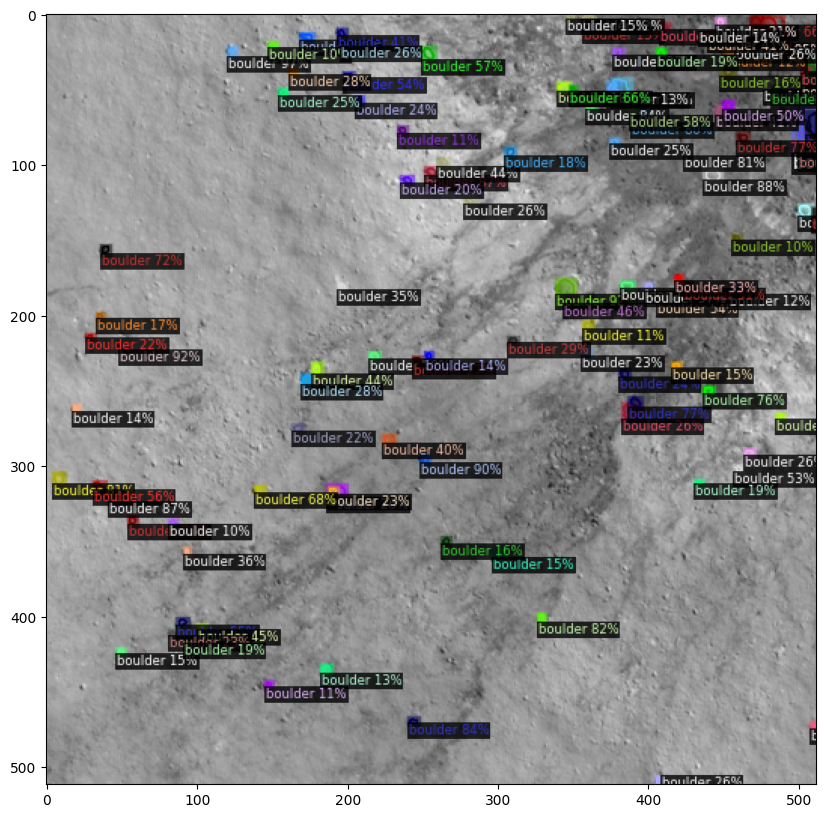

In [50]:
metadata_boulder = {"thing_classes": ["boulder"]}
v = Visualizer(im[:, :, ::-1], metadata=metadata_boulder, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,10))
mp = plotting.cv2_imshow(out.get_image()[:, :, ::-1])
ax.imshow(mp)